In [1]:
from colorscheme import colors

In [2]:
import os

os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.interpolate import UnivariateSpline

from grr.cell_class import Cell
from grr.Trace import getRisingEdges
from grr.Tools import timeToIndex
from ezephys import pltools
from ezephys.pltools import hide_border

In [4]:
DATA_PATH = os.path.join('data', 'raw', '5HT', 'spk_time')
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))

# Drop rows with drug treatment.
ctrl_fnames = fnames.loc[(fnames['PE'] == 0) & (fnames['4AP'] == 0), :]

experiments = []
for cell_id in ctrl_fnames['Cell'].unique():
    single_neuron_fnames = ctrl_fnames.loc[
        ctrl_fnames['Cell'] == cell_id, 'Recording'
    ].tolist()
    experiments.append(
        Cell().read_ABF(
            [os.path.join(DATA_PATH, fname) for fname in single_neuron_fnames]
        )
    )

In [6]:
with open(os.path.join('data', 'processed', 'gating', 'gating_params.dat'), 'rb') as f:
    gating_params = pickle.load(f)
    f.close()

In [7]:
def get_spike_latency(voltage, start_time, threshold=0., refractory_period=3., dt=0.1):
    """Get the time to the first spike after start_time.

    Returns NaN if there are no spikes after start_time, or if there are any
    spikes before start_time.

    Arguments
    ---------
    voltage : 1d float array-like
    start_time : float
    threshold : float, default 0.
        Voltage threshold for spike detection.
    refractory_period: float, default 3.
        Absolute refractory period for spike detection. Avoids detecting the
        same spike multiple times due to noise.
    dt : float, default 0.1
        Timestep of recording (ms).

    Returns
    -------
    float time from start_time until first spike (if any).

    """
    spike_inds = getRisingEdges(voltage, threshold, refractory_period)
    spike_times = spike_inds * dt

    if np.any(spike_times <= start_time):
        latency = np.nan
    elif not np.any(spike_times > start_time):
        latency = np.nan
    else:
        latency = np.min(spike_times - start_time)

    return latency

In [8]:
latency_extraction_params = {
    'V_pre_slice': slice(timeToIndex(2495.0, 0.1)[0], timeToIndex(2595.0, 0.1)[0]),
    'I_step_slice': slice(timeToIndex(2647.0, 0.1)[0], timeToIndex(2747.0, 0.1)[0]),
    'baseline_slice': slice(timeToIndex(0, 0.1)[0], timeToIndex(100., 0.1)[0]),
    'step_start_time': 2647.0,
}
latency_data = {'latency': [], 'voltage': [], 'current': []}
for expt in experiments:
    single_expt_latency = {'latency': [], 'voltage': [], 'current': []}
    for rec in expt:
        single_expt_latency['current'].append(
            (
                np.mean(rec[1, latency_extraction_params['I_step_slice'], :])
                - np.mean(rec[1, latency_extraction_params['baseline_slice'], :])
            )
        )
        for sweep in range(rec.shape[2]):
            single_expt_latency['latency'].append(
                get_spike_latency(
                    rec[0, :, sweep],
                    latency_extraction_params['step_start_time'],
                )
            )
            single_expt_latency['voltage'].append(
                np.mean(
                    rec[0, latency_extraction_params['V_pre_slice'], sweep]
                )
            )
    for key in latency_data:
        latency_data[key].append(np.array(single_expt_latency[key]))

del single_expt_latency

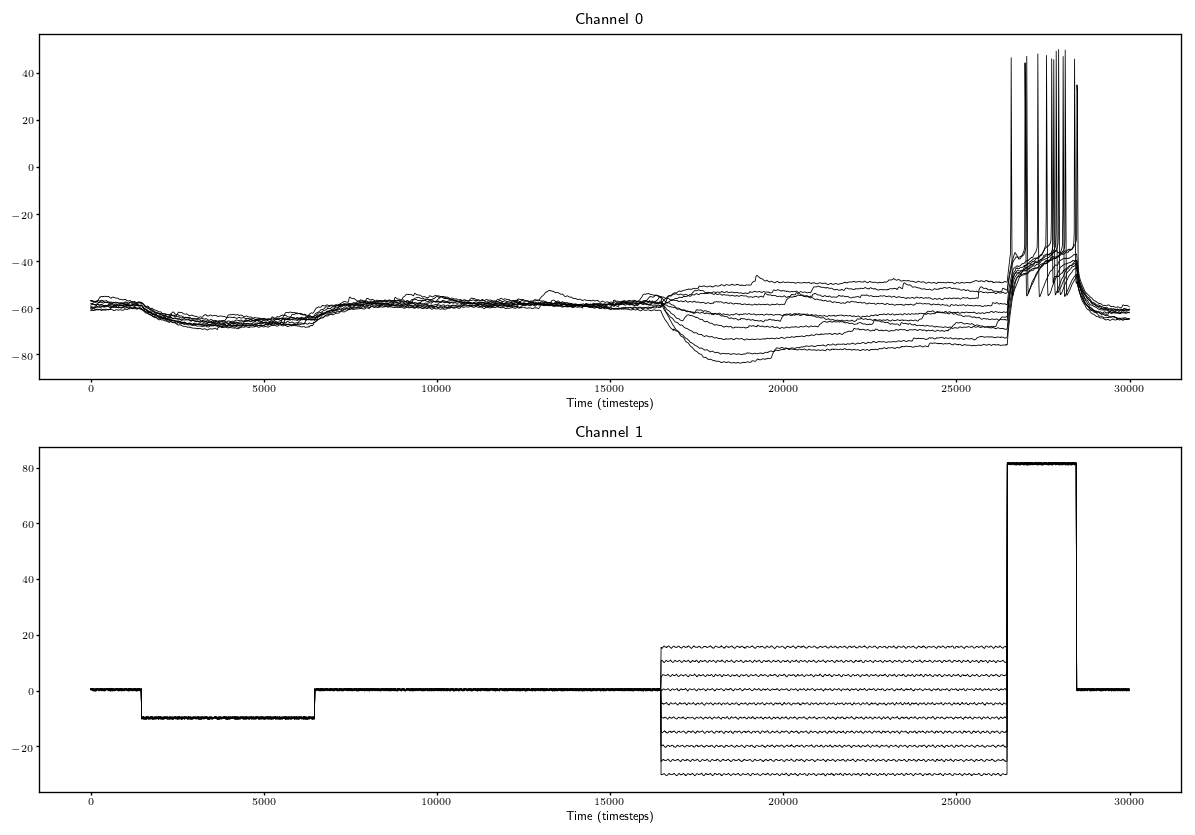

In [9]:
experiments[0][0].plot()

Colors indicate different current injections.

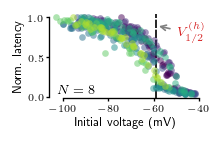

In [13]:
plt.figure(figsize=(1.7, 1))

plt.subplot(111)
plt.axvline(
    gating_params.loc['V_half', 'h'], 
    color='k', 
    ls='--', 
    dashes=(5, 1), 
    lw=1
)
plt.annotate(
    r'$V_{1/2}^{(h)}$',
    (gating_params.loc['V_half', 'h'], 0.9),
    xytext=(-50, 0.7),
    xycoords='data',
    textcoords='data',
    arrowprops={'arrowstyle': '->'},
    color=colors['h']
)
for i, (latencies, voltages) in enumerate(zip(latency_data['latency'], latency_data['voltage'])):
    plt.plot(
        voltages, 
        latencies / np.nanmax(latencies), 
        'o',
        alpha=0.5,
        color=plt.cm.viridis(float(i)/len(latency_data['latency'])),
        markeredgecolor='none',
        markersize=4,
        clip_on=False
    )
plt.text(
    0.05, 
    0.05, 
    '$N = {}$'.format(len(latency_data['latency'])), 
    transform=plt.gca().transAxes
)

plt.xlabel('Initial voltage (mV)')
plt.ylabel('Norm. latency')
hide_border('tr', trim=True)

plt.subplots_adjust(bottom=0.25, left=0.2, top=0.95, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_latency_steps.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_latency_steps.svg'))

Colors indicate different cells.

# Splines

Too wiggly.

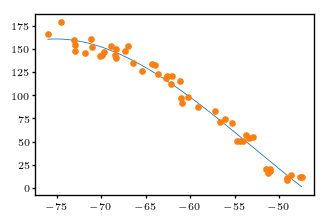

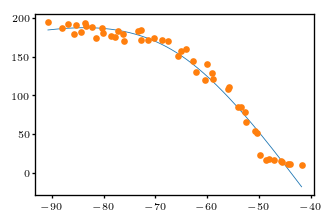

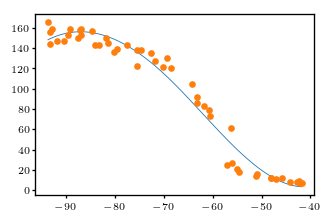

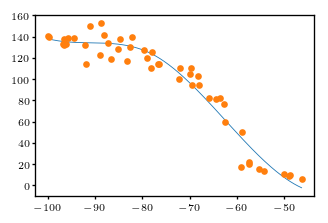

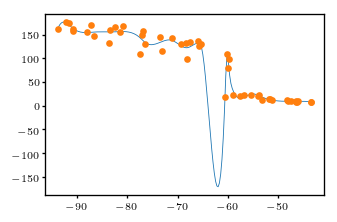

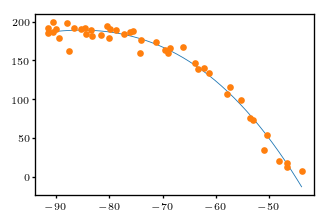

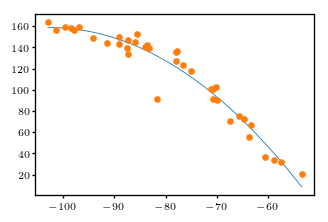

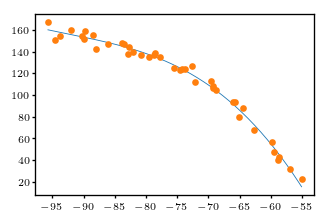

In [14]:
for latencies, voltages in zip(latency_data['latency'], latency_data['voltage']):
    inds = np.argsort(voltages)
    voltages_sorted = voltages[inds]
    latencies_sorted = latencies[inds]
    
    spl = UnivariateSpline(
        voltages_sorted[~np.isnan(latencies_sorted)], 
        latencies_sorted[~np.isnan(latencies_sorted)], 
        s=5e3
    )
    x = np.linspace(np.nanmin(voltages_sorted[~np.isnan(latencies_sorted)]), np.nanmax(voltages_sorted[~np.isnan(latencies_sorted)]), 200)
    
    plt.figure()
    plt.plot(x, spl(x))
    plt.plot(voltages_sorted, latencies_sorted, '.')
    plt.show()

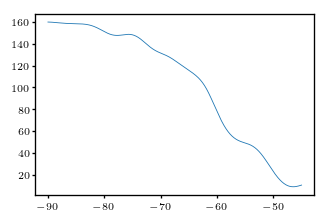

In [15]:
all_latencies = np.concatenate(latency_data['latency'])
all_voltages = np.concatenate(latency_data['voltage'])

inds = np.argsort(all_voltages)
all_voltages_sorted = all_voltages[inds]
all_latencies_sorted = all_latencies[inds]

spl = UnivariateSpline(
    all_voltages_sorted[~np.isnan(all_latencies_sorted)], 
    all_latencies_sorted[~np.isnan(all_latencies_sorted)],
    k=4,
    s=2.35e5
)

x = np.linspace(-90, -45, 500)
plt.plot(x, spl(x))

# Pharmacology

In [16]:
pharmacology_fnames = {
    'baseline': ['18627043.abf', '18627044.abf', '18627045.abf', '18627046.abf', '18627047.abf'],
    '4AP': ['18627053.abf', '18627054.abf', '18627055.abf'],
    #'wash': ['18627062.abf', '18627063.abf', '18627064.abf']
}
pharmacology_recs = {
    cond: Cell().read_ABF(
        [os.path.join(DATA_PATH, fname) for fname in pharmacology_fnames[cond]]
    ) for cond in pharmacology_fnames
}

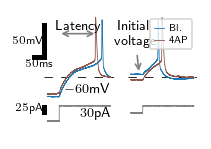

In [17]:
sweeps = {
    'lo': 1,
    'hi': 8
}
sample_rec = 0

spec_4AP = gs.GridSpec(2, 2, height_ratios = [1, 0.2], hspace = 0.1)

plt.figure(figsize = (1.7, 1))

### B: real neurons

trace_time_slice = slice(25400, 28400)
t_vec = np.arange(0, 300, 0.1)
V_ax_lo = plt.subplot(spec_4AP[0, 0])
#plt.title(' 5HT neuron', loc = 'left')
plt.axhline(-60, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
plt.annotate('$-60$mV', (300, -65), ha = 'right', va = 'top')
plt.annotate('', (50, 9), (240, 9), arrowprops = {'arrowstyle': '<->'})
plt.text(150, 14, 'Latency', ha = 'center')
plt.ylim(-95, 40)

I_ax_lo = plt.subplot(spec_4AP[1, 0])
plt.annotate('$30$pA', (300, 28), ha = 'right', va = 'top')


# Sweeps 3 and 8
V_ax_lo.plot(
    t_vec, pharmacology_recs['baseline'][sample_rec][0, trace_time_slice, sweeps['lo']],
    '-', color=colors['ser']
)
V_ax_lo.plot(
    t_vec, pharmacology_recs['4AP'][sample_rec][0, trace_time_slice, sweeps['lo']],
    '-', color=colors['4AP']
)
I_ax_lo.plot(
    t_vec, pharmacology_recs['baseline'][sample_rec][1, trace_time_slice, sweeps['lo']], 
    color=colors['input']
)

pltools.add_scalebar(
    y_units = 'mV', x_units = 'ms', anchor = (0, 0.5),
    x_size = 50,
    bar_space = 0, ax = V_ax_lo
)
pltools.add_scalebar(
    y_units='pA', anchor=(0, 0.5),
    omit_x=True,
    ax=I_ax_lo
)

V_ax_hi = plt.subplot(spec_4AP[0, 1])
plt.axhline(-60, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
#plt.annotate('$-60$mV', (300, -65), ha = 'right', va = 'top')
plt.ylim(V_ax_lo.get_ylim())

I_ax_hi = plt.subplot(spec_4AP[1, 1])
#plt.annotate('30pA', (300, 28), ha = 'right', va = 'top')
I_ax_hi.set_ylim(I_ax_lo.get_ylim())

V_ax_hi.plot(
    t_vec, pharmacology_recs['baseline'][sample_rec][0, trace_time_slice, sweeps['hi']],
    '-', color=colors['ser'], label='Bl.'
)
V_ax_hi.plot(
    t_vec, pharmacology_recs['4AP'][sample_rec][0, trace_time_slice, sweeps['hi']],
    '-', color=colors['4AP'], label='4AP'
)
I_ax_hi.plot(
    t_vec, pharmacology_recs['baseline'][sample_rec][1, trace_time_slice, sweeps['hi']], 
    color=colors['input']
)
V_ax_hi.legend()

V_ax_hi.annotate(
    'Initial\nvoltage',
    (40, -55),
    xytext=(20, -10),
    xycoords='data',
    textcoords='data',
    arrowprops={'arrowstyle': '->'},
    ha='center'
)

pltools.hide_border(ax = V_ax_hi)
pltools.hide_ticks(ax = V_ax_hi)
pltools.hide_border(ax = I_ax_hi)
pltools.hide_ticks(ax = I_ax_hi)

plt.subplots_adjust(left=0.15, bottom=0.05, top=0.95, right=0.90)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'pharmacology_sample_traces.png'))
    plt.savefig(os.path.join(IMG_PATH, 'pharmacology_sample_traces.svg'))

In [18]:
latency_extraction_params = {
    'V_pre_slice': slice(timeToIndex(2495.0, 0.1)[0], timeToIndex(2595.0, 0.1)[0]),
    'I_step_slice': slice(timeToIndex(2647.0, 0.1)[0], timeToIndex(2747.0, 0.1)[0]),
    'baseline_slice': slice(timeToIndex(0, 0.1)[0], timeToIndex(100., 0.1)[0]),
    'step_start_time': 2647.0,
}
pharmacology_latencies = {
    condition: {'latency': [], 'voltage': [], 'current': []} for condition in pharmacology_recs
}
for condition in pharmacology_recs:
    single_expt_latency = {'latency': [], 'voltage': [], 'current': []}
    for rec in pharmacology_recs[condition]:
        single_expt_latency['current'].append(
            (
                np.mean(rec[1, latency_extraction_params['I_step_slice'], :])
                - np.mean(rec[1, latency_extraction_params['baseline_slice'], :])
            )
        )
        for sweep in range(rec.shape[2]):
            single_expt_latency['latency'].append(
                get_spike_latency(
                    rec[0, :, sweep],
                    latency_extraction_params['step_start_time'],
                )
            )
            single_expt_latency['voltage'].append(
                np.mean(
                    rec[0, latency_extraction_params['V_pre_slice'], sweep]
                )
            )
    for key in latency_data:
        pharmacology_latencies[condition][key].append(np.array(single_expt_latency[key]))

del single_expt_latency

In [19]:
print(pharmacology_latencies['baseline']['current'])
print(pharmacology_latencies['4AP']['current'])

[array([40.71760254, 40.7173645 , 40.72047729, 40.72081299, 40.71875   ])]
[array([40.72170149, 40.72194999, 40.72413417])]


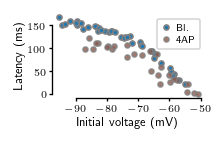

In [20]:
plt.figure(figsize=(1.7, 1))

plt.subplot(111)
plt.plot(
    np.asarray(pharmacology_latencies['baseline']['voltage']).flatten(), 
    np.asarray(pharmacology_latencies['baseline']['latency']).flatten(), 
    'o',
    color=colors['ser'],
    markeredgecolor='gray',
    markersize=3,
    label='Bl.',
    clip_on=False
)
plt.plot(
    np.asarray(pharmacology_latencies['4AP']['voltage']).flatten(), 
    np.asarray(pharmacology_latencies['4AP']['latency']).flatten(), 
    'o',
    color=colors['4AP'],
    alpha=0.8,
    markeredgecolor='gray',
    markersize=3,
    label='4AP',
    clip_on=False
)
#plt.ylim(-50, plt.ylim()[1])
plt.legend()
#plt.yticks([0, 75, 150])
hide_border('tr', trim=True)
plt.xlabel('Initial voltage (mV)')
plt.ylabel('Latency (ms)')

plt.subplots_adjust(left=0.2, bottom=0.25, right=0.95, top=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'pharmacology_latency.png'))
    
plt.show()